# base_model

> In this module we have the base model, learner and other things we need to train encoder with Barlow Twins and other methods.
 

In [1]:
#| default_exp base_model

In [2]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [3]:
#| export
import importlib
import sys
import self_supervised
import torch
import torch.nn.functional as F
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import kornia.augmentation as korniatfm
import torchvision.transforms as tvtfm
from base_rbt.utils import *

Here we have the base functions and classes to train a basic BT-style model. Note that this (mostly) all comes directly from here: `https://github.com/KeremTurgutlu/self_supervised/blob/main/nbs/14%20-%20barlow_twins.ipynb`
but we needed to extend some of the functionality for our purposes. 

Some of the base classes and functions needed for image augmentation pipeline:

In [4]:
#| export

#My edited version of RandTransform
class RandomGaussianBlur(RandTransform):
    "Randomly apply gaussian blur with probability `p` with a value of s"
    order = 11
    def __init__(self, 
                 p=1.0, #debugging (bug in libraries implementation)
                 prob=0.5,#the real probability
                 s=(8,32), #kernel
                 sig=None, #sig_val is either manually input OR
                 blur_r=(0.1,2),#is randomly chosen from uniform with these bounds
                 same_on_batch=False, 
                 **kwargs): 
        
        store_attr()
        super().__init__(p=p, **kwargs)

    def encodes(self, x:TensorImage):
        
        if isinstance(self.s, int):   s = (self.s,self.s)
        elif isinstance(self.s, tuple) or isinstance(self.s, list): s=self.s
     
        #Default for ImageNet from BYOL / BT papers
        if self.sig is None:
            sig_val = np.random.uniform(self.blur_r[0],self.blur_r[1])
        
        else:
            sig_val = self.sig
            

        tfm = korniatfm.RandomGaussianBlur(kernel_size=s,sigma=(sig_val,sig_val),same_on_batch=self.same_on_batch,p=self.prob)
        return tfm(x)

#Delete later: leaving for backward compatibility for now
# class RandomGaussianBlur(RandTransform):
#     "Randomly apply gaussian blur with probability `p` with a value of s"
#     order = 11
#     def __init__(self, p=0.5, s=(8,32), same_on_batch=False, **kwargs): 
#         store_attr()
#         super().__init__(p=p, **kwargs)
        
#     def encodes(self, x:TensorImage):
#         if isinstance(self.s, tuple): s = np.random.randint(*self.s)
#         if isinstance(self.s, list):  s = np.random.randint(*self.s)
#         if isinstance(self.s, int):   s = self.s
#         s2 = int(s/4)*2+1
#         tfm = korniatfm.RandomGaussianBlur((s2,s2),(s,s),same_on_batch=self.same_on_batch,p=1.) #p=1. is a bug
#                                             #kernel #sigma
        
#         return tfm(x)


class RandomCenterDropout(torch.nn.Module):
    def __init__(self, p=0.5, min_dropout_size=(20, 20), max_dropout_size=(60, 60), fill_value=0, same_on_batch=False):
        super().__init__()
        self.p = p
        self.min_dropout_size = min_dropout_size
        self.max_dropout_size = max_dropout_size
        self.fill_value = fill_value
        self.same_on_batch = same_on_batch
        #self.id_transform = tvtfm.RandomResizedCrop((256, 256), scale=(1.,1.), ratio=(1.,1.))


    def forward(self, x):
        # Check if the augmentation should be applied to the whole batch or individually

        #x=self.id_transform(x)

        if self.same_on_batch:
            if random.random() < self.p:
                return self._apply_dropout(x)
            else:
                return x
        else:
            # Apply dropout individually with given probability
            for i in range(x.size(0)):
                tem=random.random()
                #print(f"tem is: {tem}")
                if tem < self.p:
                    x[i] = self._apply_dropout(x[i].unsqueeze(0)).squeeze(0)
            return x

    def _apply_dropout(self, img):
        for i,count in enumerate(range(img.size(0))):  # Iterate through batch if necessary
            _, h, w = img[i].shape
            # Generate random dropout size within specified limits
            dh = random.randint(self.min_dropout_size[0], self.max_dropout_size[0])
            dw = random.randint(self.min_dropout_size[1], self.max_dropout_size[1])
            
            x1 = int(max((w - dw) / 2, 0))
            y1 = int(max((h - dh) / 2, 0))
            
            mask = torch.ones_like(img[i])
            mask[:, y1:y1+dh, x1:x1+dw] = self.fill_value
            img[i] = img[i] * mask
        
        return img

    
def get_BT_batch_augs(size,
                    flip=True,crop=True,noise=True,rotate=True,jitter=True,bw=True,blur=True,solar=True,cutout=False, #Whether to use  given aug or not
                    resize_scale=(0.08, 1.0),resize_ratio=(3/4, 4/3),noise_std=0.025, rotate_deg=30,jitter_s=.6,blur_s=(4,32),#hps of diff augs
                    blur_r=(0.1,2),blur_sig=None,sol_t=0.05,sol_a=0.05,min_dropout_size=(25, 100),max_dropout_size=(50,150), #hps of diff augs
                    flip_p=0.5, rotate_p=0.3,noise_p=0.2, jitter_p=0.3, bw_p=0.3, blur_p=0.3,sol_p=0.1,cut_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=imagenet_stats,cuda=default_device().type == 'cuda',xtra_tfms=[]
                    ):
    "Input batch augmentations implemented in tv+kornia+fastai"
    
    tfms = []

    korniatfm.RandomHorizontalFlip.order = RandomResizedCrop.order-1


    if crop: tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
    #Unfortunately for some reason this doesn't work, so we can't apply "same_on_batch=False"
    #tfms += [korniatfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio, same_on_batch=same_on_batch)]

    if cutout: tfms+=[RandomCenterDropout(min_dropout_size=min_dropout_size,max_dropout_size=max_dropout_size, fill_value=0, p=cut_p,same_on_batch=same_on_batch)]
    
  
    if flip: tfms += [korniatfm.RandomHorizontalFlip(p=flip_p,same_on_batch=same_on_batch)]

    if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

                                             #brightness,contrast,saturation,hue
    if jitter: tfms += [korniatfm.ColorJitter(0.4*jitter_s, 0.4*jitter_s, 0.2*jitter_s, 0.1*jitter_s, p=jitter_p, same_on_batch=same_on_batch)]
    
    if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]
        
    #sig will usually be None
    if blur:   tfms += [RandomGaussianBlur(prob=blur_p, s=blur_s,sig=blur_sig,blur_r=blur_r, same_on_batch=same_on_batch)]

    korniatfm.RandomSolarize.order = RandomGaussianBlur.order + 1 #we want to apply solarization after RandomGaussianBlur
    
    if solar: tfms += [korniatfm.RandomSolarize(p=sol_p,thresholds=sol_t, additions=sol_a,same_on_batch=same_on_batch)]

    if noise: tfms+=[korniatfm.RandomGaussianNoise(mean=0.0, std=noise_std, same_on_batch=same_on_batch, p=noise_p)]
    
    if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

    tfms += xtra_tfms

    pipe = Pipeline(tfms, split_idx = 0)
    return pipe

@delegates(get_BT_batch_augs)
def get_multi_aug_pipelines(size, **kwargs): return get_BT_batch_augs(size, **kwargs)

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(size=size,**kwargs)


In [5]:
#| export

def get_bt_cifar10_aug_pipelines(size):
    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                                                    bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                    resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,
                                                    bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.5,sol_p=0.0,
                                                    stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                    )

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                                                    bw=True, rotate=True,noise=True, jitter=True, blur=True,solar=True,
                                                    resize_scale=(0.4, 1.0),rotate_deg=45,noise_std=0.0125, jitter_s=1.0, blur_s=math.ceil(size/10)+1,sol_t=0.01,sol_a=0.01,
                                                    bw_p=0.2, flip_p=0.5,rotate_p=0.25,noise_p=0.5, jitter_p=0.5, blur_p=0.1,sol_p=0.2,
                                                    stats=cifar_stats,same_on_batch=False, xtra_tfms=[]
                                                    )

    bt_cifar10_aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

    return bt_cifar10_aug_pipelines

#Add other augmentations here e.g. BYOL augs
IMAGENET_Augs = dict(flip_p1=0.5,flip_p2=0.5,jitter_p1=0.8,jitter_p2=0.8,bw_p1=0.2,
                bw_p2=0.2,blur_p1=1.0,blur_p2=0.1,sol_p1=0.0,sol_p2=0.2,noise_p1=0.0,
                noise_p2=0.0,cut_p=0,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                rotate_p=0.5,blur_r=(0.1,2),blur_s=13,sol_t=0.1,sol_a=0.1,noise_std=0.1,min_dropout_size=None,max_dropout_size=None,
                )

DERMNET_Augs = IMAGENET_Augs.copy()
DERMNET_Augs['min_dropout_size']=(50, 185)
DERMNET_Augs['max_dropout_size']=(100,190)
DERMNET_Augs['cut_p']=0.33

def helper_get_bt_augs(size,Augs=IMAGENET_Augs):


    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True,cutout=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        min_dropout_size=Augs['min_dropout_size'],max_dropout_size=Augs['max_dropout_size'],
                        flip_p=Augs['flip_p1'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p1'],
                        jitter_p=Augs['jitter_p1'], bw_p=Augs['bw_p1'], blur_p=Augs['blur_p1'],
                        sol_p=Augs['sol_p1'],cut_p=Augs['cut_p'], #prob of performing aug
                        same_on_batch=False,stats=None)

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True,cutout=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        min_dropout_size=Augs['min_dropout_size'],max_dropout_size=Augs['max_dropout_size'],
                        flip_p=Augs['flip_p2'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p2'],
                        jitter_p=Augs['jitter_p2'], bw_p=Augs['bw_p2'], blur_p=Augs['blur_p2'],
                        sol_p=Augs['sol_p2'],cut_p=Augs['cut_p'], #prob of performing aug
                        same_on_batch=False,stats=None)

    aug_pipelines = [aug_pipelines_1,aug_pipelines_2]

    return aug_pipelines

def get_bt_imagenet_aug_pipelines(size):
    return helper_get_bt_augs(size,Augs=IMAGENET_Augs)

def get_bt_dermnet_aug_pipelines(size):
    return helper_get_bt_augs(size,Augs=DERMNET_Augs)



bt_aug_func_dict = {'bt_cifar10_aug_pipelines':get_bt_cifar10_aug_pipelines,'bt_imagenet_aug_pipelines':get_bt_imagenet_aug_pipelines,
                   'bt_dermnet_aug_pipelines':get_bt_dermnet_aug_pipelines
                   }

def get_bt_aug_pipelines(bt_augs,size):

    return bt_aug_func_dict[bt_augs](size)

    

In [6]:
#| export

def get_ssl_dls(dataset,#cifar10, dermnet, etc
            bs,
            size,
            device,
            pct_dataset=1.0):
    # Define the base package name in a variable for easy modification

    try:
        # Construct the module path
        module_path = f"{PACKAGE_NAME}.{dataset}_dataloading"
        
        # Dynamically import the module
        dataloading_module = importlib.import_module(module_path)
    except ModuleNotFoundError:
        # Handle the case where the module cannot be found
        raise ImportError(f"Could not find a data loading module for '{dataset}'. "
                          f"Make sure '{module_path}' exists and is correctly named.") from None
    
    # Assuming the function name follows a consistent naming convention
    func_name = f"get_bt_{dataset}_train_dls"

    try:
        # Retrieve the data loading function from the module
        data_loader_func = getattr(dataloading_module, func_name)
    except AttributeError:
        # Handle the case where the function does not exist in the module
        raise AttributeError(f"The function '{func_name}' was not found in '{module_path}'. "
                             "Ensure it is defined and named correctly.") from None
    
    # Proceed to call the function with arguments from the config
    try:
        dls_train = data_loader_func(bs=bs,size=size,device=device,pct_dataset=pct_dataset)
    except Exception as e:
        # Handle any errors that occur during the function call
        raise RuntimeError(f"An error occurred while calling '{func_name}' from '{module_path}': {e}") from None
    
    return dls_train


Base functions / classes we need to train a BT / RBT model.

In [7]:
#| export
#Base functions / classes we need to train a BT / RBT model.

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...

# class BarlowTwinsModel(Module):
#     """An encoder followed by a projector
#     """
#     def __init__(self,encoder,projector):
#         self.encoder = encoder
#         self.projector = projector
        
#     def forward(self,x): 
        
#         return self.projector(self.encoder(x))

# def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
#     "Create Barlow Twins model"
#     n_in  = in_channels(encoder)
#     with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
#     projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
#     apply_init(projector)
#     return BarlowTwinsModel(encoder, projector)


#We want access to both representation and projection

#TODO: We can make these more abstract so can incrementally modify to build `bt/rbt` and also `new idea.` But for 
#sake of readability, might be easier to just modify the defintions elsewhere. Come back to this later...
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):
        self.encoder = encoder
        self.projector = projector
        
    def forward(self,x): 
        tem = self.encoder(x)
        return tem,self.projector(tem) #get access to both representation and projection if needed for loss
    
    def __str__(self):
        return 'forward returns tuple of (encoder(x),projector(encoder(x)))'

def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
 
    return BarlowTwinsModel(encoder, projector)


#Note: this requires an lf (loss function), which is patched in later.
#The reason for this is we can specify via a string argument (e.g. via
#a config file) what loss function we want to use. lf_bt is the default
#(standard barlow twins loss function).
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in,lmb,sparsity_level, 
                model_type='barlow_twins',print_augs=False
                 ):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        store_attr('sparsity_level')
        self.n_in=n_in
        self.model_type = model_type
        self.index=-1 #Gets updated after each batch
        self.acc_dict = {}
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)


    def before_epoch(self):
        self.index=-1  
  
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:

            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
            
            #print(xi.shape)
                                    
        elif self.n_in == 3:
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (torch.cat([xi, xj]),)
 
        
    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

We can modify the above for vicreg:

In [42]:
#| export

# Base functions / classes we need to train a 
#  model
class VICRegModel(Module):
    """VICReg model with options for shared or separate projectors"""
    def __init__(self, left_encoder, right_encoder, left_projector, right_projector):
        #may have right_encoder = encoder_left and right_projector = left_projector.
        #or e.g. encoders may have shared weights.
        self.left_encoder = left_encoder
        self.right_encoder = right_encoder
        self.left_projector = left_projector
        self.right_projector = right_projector
        
    def forward(self,x): #x is stacked xi,xj the two augmented views of batch
      
        x1, x2 = x[:x.size(0)//2], x[x.size(0)//2:]
        
        z1,z2 = self.left_projector(self.left_encoder(x1)), self.right_projector(self.right_encoder(x2))
    
        return z1, z2

def create_vicreg_model(left_encoder, right_encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3, shared_projector=True):
    """
    Create VICReg model with flexible projector configuration
    
    Args:
    - left_encoder: first encoder model
    - right_encoder: second encoder model (can be the same as left_encoder for shared encoder)
    - hidden_size: hidden size for projector
    - projection_size: output size for projector
    - bn: whether to use batch normalization in projector
    - nlayers: number of layers in projector
    - shared_projector: if True, use the same projector for both branches
    """
    n_in = in_channels(left_encoder)
    with torch.no_grad(): representation = left_encoder(torch.randn((2,n_in,128,128)))
    
    left_projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
    apply_init(left_projector)
    
    if not shared_projector:
        right_projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers)
        apply_init(right_projector)
    else:
        right_projector = left_projector
    
    return VICRegModel(left_encoder, right_encoder, left_projector, right_projector)

#helper function to compute vicreg loss.
def off_diagonal(x):
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class VICReg(BarlowTwins):
    def __init__(self, aug_pipelines, n_in=3, sim_coeff=25, std_coeff=25, cov_coeff=1, 
                 model_type='vicreg', print_augs=False):
        super().__init__(aug_pipelines, n_in, None, None, model_type, print_augs)
        self.sim_coeff = sim_coeff
        self.std_coeff = std_coeff
        self.cov_coeff = cov_coeff
        self.model_type = model_type

    def before_fit(self):
        self.learn.loss_func = self.lf

    def lf(self, pred, *yb):
        x, y = pred  # Assuming the model returns two views (see VICRegModel)

        # Invariance loss
        repr_loss = F.mse_loss(x, y)

        # Variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        # Covariance loss
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        cov_x = (x.T @ x) / (x.size(0) - 1)
        cov_y = (y.T @ y) / (y.size(0) - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(x.size(1)) + \
                   off_diagonal(cov_y).pow_(2).sum().div(y.size(1))

        # Total loss
        loss = (
            self.sim_coeff * repr_loss +
            self.std_coeff * std_loss +
            self.cov_coeff * cov_loss
        )

        return loss

    def before_batch(self):
        #if self.model_type == 'br_vicreg':

    #         # Create two copies of the input
    #         x_left, x_right = self.x.clone(), self.x.clone()
            
    #         # Zero out the right half of x_left and the left half of x_right
    #         mid = x_left.shape[-1] // 2
    #         x_left[..., mid:] = 0
    #         x_right[..., :mid] = 0
            
    #         print(f"x shape: {self.x.shape}")
    #         print(f"x_left shape: {x_left.shape}")
    #         print(f"x_right shape: {x_right.shape}")

    #         # Apply augmentations
    #         if self.n_in == 1:
    #             xi = self.aug1(TensorImageBW(x_left))
    #             xj = self.aug2(TensorImageBW(x_right))
    #         elif self.n_in == 3:
    #             xi = self.aug1(TensorImage(x_left))
    #             xj = self.aug2(TensorImage(x_right))

    #         print(f"xi shape after aug: {xi.shape}")
    #         print(f"xj shape after aug: {xj.shape}")

    #         # Concatenate the augmented halves
    #         self.learn.xb = (torch.cat([xi, xj], dim=0),)
    #         print(f"Final self.learn.xb shape: {self.learn.xb[0].shape}")

        # The above splits x into x_left and x_right, with padding, then applies
        # aug1 and aug2. Alternatively, we could compute aug1(x) and aug2(x). 
        # then zero pad the right half of aug1(x) and the left half of aug2(x).

        #zero padding approach:
        # if self.model_type == 'br_vicreg':
        #     # Apply augmentations first
        #     if self.n_in == 1:
        #         xi = self.aug1(TensorImageBW(self.x))
        #         xj = self.aug2(TensorImageBW(self.x))
        #     elif self.n_in == 3:
        #         xi = self.aug1(TensorImage(self.x))
        #         xj = self.aug2(TensorImage(self.x))
            
        #     print(f"x shape: {self.x.shape}")
        #     print(f"xi shape after aug: {xi.shape}")
        #     print(f"xj shape after aug: {xj.shape}")

        #     # Zero out the right half of xi and the left half of xj
        #     mid = xi.shape[-1] // 2
        #     xi[..., mid:] = 0
        #     xj[..., :mid] = 0
            
        #     print(f"xi shape after zeroing: {xi.shape}")
        #     print(f"xj shape after zeroing: {xj.shape}")

        #     # Concatenate the augmented and zeroed halves
        #     self.learn.xb = (torch.cat([xi, xj], dim=0),)
        #     print(f"Final self.learn.xb shape: {self.learn.xb[0].shape}")
        # else:
        #     # Use the original BarlowTwins before_batch method for 'vicreg'
        #     if self.n_in == 1:
        #         xi, xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
        #     elif self.n_in == 3:
        #         xi, xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
        #     self.learn.xb = (torch.cat([xi, xj], dim=0),)

        #here we dont zero pad at all, just get 16x32 (for cifar, say)
        if self.model_type == 'br_vicreg':
            # Apply augmentations first
            if self.n_in == 1:
                xi = self.aug1(TensorImageBW(self.x))
                xj = self.aug2(TensorImageBW(self.x))
            elif self.n_in == 3:
                xi = self.aug1(TensorImage(self.x))
                xj = self.aug2(TensorImage(self.x))
            
            # Dynamically calculate the split point
            _, _, height, width = xi.shape
            split_point = width // 2

            # Split each image into left and right halves
            xi_left = xi[..., :split_point]  # Left half
            xj_right = xj[..., split_point:]  # Right half
            
            # Concatenate the halves
            self.learn.xb = (torch.cat([xi_left, xj_right], dim=0),)

            print(f"Input shape: {self.x.shape}")
            print(f"Augmented left half shape: {xi_left.shape}")
            print(f"Augmented right half shape: {xj_right.shape}")
            print(f"Combined batch shape: {self.learn.xb[0].shape}")

        else:
            # Original implementation for 'vicreg'
            if self.n_in == 1:
                xi, xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
            elif self.n_in == 3:
                xi, xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
            self.learn.xb = (torch.cat([xi, xj], dim=0),)


Definition of barlow twins loss and sparse barlow twins loss functions, and proposes modifications

In [11]:
#| export
def lf_bt(pred,I,lmb): #standard bt loss
    bs,nf = pred.size(0)//2,pred.size(1)
    
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    C = (z1norm.T @ z2norm) / bs 
    cdiff = (C - I)**2
    loss = (cdiff*I + cdiff*(1-I)*lmb).sum() 
    return loss

In [12]:
#| export
def lf_bt_sparse_head(pred,I,lmb,projector,sparsity_level):
  
    bt_loss = lf_bt(pred,I,lmb)
    L21 = torch.linalg.norm(projector[-1].weight, ord=2, dim=0).sum()

    # print(f"bt_loss is {bt_loss}, L21 is {L21}, scaled L21 is {sparsity_level*L21}")
    # print(bt_loss)
    # print(L21)

    
    loss =  bt_loss + sparsity_level*L21 #barlow twins loss + L21 norm of last layer of projector
 
    return loss

In [13]:
#| export
def lf_bt_indiv_sparse(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]

    sparsity = lmb*(0.5*torch.abs(z1_enc) + 0.5*torch.abs(z2_enc)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

    


In [14]:
#| export
def lf_bt_group_sparse(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]

    sparsity = lmb * ((0.5 * z1_enc.pow(2) + 0.5 * z2_enc.pow(2)).pow(0.5)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [15]:
#| export
def lf_bt_group_norm_sparse(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    

    eps = 1e-7
    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / (z1_enc.std(0, unbiased=False)+eps)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / (z2_enc.std(0, unbiased=False)+eps)

    sparsity = lmb * ((0.5 * z1norm_enc.pow(2) + 0.5 * z2norm_enc.pow(2)).pow(0.5)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [16]:
#| export
def lf_bt_fun(pred,I,lmb,sparsity_level,
                      ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
    

    eps = 1e-7
    z1_enc, z2_enc = pred_enc[:bs],pred_enc[bs:]
    z1norm_enc = (z1_enc - z1_enc.mean(0)) / (z1_enc.std(0, unbiased=False)+eps)
    z2norm_enc = (z2_enc - z2_enc.mean(0)) / (z2_enc.std(0, unbiased=False)+eps)

    sparsity = lmb * ((0.5 * z1norm_enc.pow(2) + 0.5 * z2norm_enc.pow(2)).pow(0.5)).sum()

    C = (z1norm_enc.T @ z2norm_enc) / bs
    cdiff = (C - I)**2

    loss = (cdiff*I).sum() #standard bt loss

    print(f"invariance loss is: {loss} and sparsity loss is: {sparsity}")

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

In [17]:
#| export
def lf_bt_proj_group_sparse(pred,I,lmb,sparsity_level,
                           ):

    pred_enc = pred[0]
    pred = pred[1]

    bs,nf = pred.size(0)//2,pred.size(1)

    #All standard, from BT
    z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
    z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)

    sparsity = lmb * ((0.5 * z1norm.pow(2) + 0.5 * z2norm.pow(2)).pow(0.5)).sum()

    C = (z1norm.T @ z2norm) / bs
    cdiff = (C - I)**2

    rr = cdiff*(1-I)*lmb #redundancy reduction term (scaled by lmb)

    loss = (cdiff*I + rr).sum() #standard bt loss

    loss = loss + sparsity_level*sparsity

    torch.cuda.empty_cache()
    return loss

Patch in loss function:

In [18]:
#| export

@patch
def lf(self:BarlowTwins, pred,*yb):
    "Assumes model created according to type p3"

    if self.model_type=='barlow_twins':
         pred_enc = pred[0]
         pred = pred[1]
         return lf_bt(pred, self.I,self.lmb)

    elif self.model_type=='sparse_head_barlow_twins':
        pred_enc = pred[0]
        pred = pred[1]

        return lf_bt_sparse_head(pred, self.I,lmb=self.lmb,projector=self.learn.model.projector,sparsity_level=self.sparsity_level)
    

    elif self.model_type=='indiv_sparse_barlow_twins':
        return lf_bt_indiv_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)
    
    elif self.model_type=='group_sparse_barlow_twins':
        return lf_bt_group_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)

    elif self.model_type=='group_norm_sparse_barlow_twins':
        return lf_bt_group_norm_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)

    elif self.model_type=='proj_group_sparse_barlow_twins':
        return lf_bt_proj_group_sparse(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)
    
    elif self.model_type=='fun':
        return lf_bt_fun(pred, self.I,lmb=self.lmb,sparsity_level=self.sparsity_level)


    else: raise(Exception)

In [19]:
#| export
def my_splitter_bt(m):
    return L(sequential(*m.encoder),m.projector).map(params)

In [20]:
#| export
def my_splitter_bt_last_block_resnet50(m):
    #Note: don't think we actually need this guy.
    "Freeze all but the last bottleneck layer"
    enc_except_final_block = sequential(*m.encoder[:-3], m.encoder[-3][:-1])
    final_block_and_projector = sequential(m.encoder[-3][-1], m.projector)
    return L(enc_except_final_block, final_block_and_projector).map(params)

Here we show how to use the above functions in an end to end fashion. First we get some data and plonk it into a dls, Then create an encoder, an augmentation pipeline, a learner, then fit
the learner. This is the complete process of training BT. 

In [21]:
#| export
def show_bt_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwins(aug,n_in=n_in,lmb=None,sparsity_level=None,
                                                     print_augs=print_augs
                                        )])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins.show(n=n)

def show_vicreg_batch(dls,n_in,aug,n=2,print_augs=True,model_type='vicreg'):
    "Given a linear learner, show a batch"

    learn = Learner(dls,model=None, cbs=[VICReg(aug,n_in=3,model_type=model_type)])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.vic_reg.show(n=n)


Input shape: torch.Size([64, 3, 32, 16])
Augmented left half shape: torch.Size([32, 3, 32, 16])
Augmented right half shape: torch.Size([32, 3, 32, 16])
Combined batch shape: torch.Size([64, 3, 32, 16])


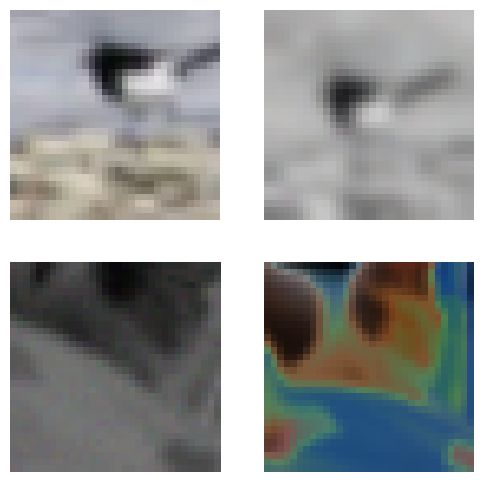

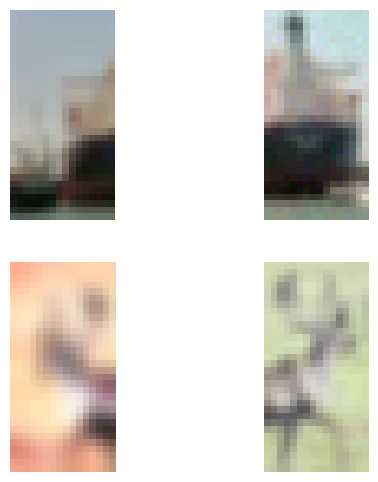

In [22]:
#|hide 

dls = get_ssl_dls('cifar10',bs=32,size=128,device=default_device())
aug = get_bt_cifar10_aug_pipelines(32)
show_vicreg_batch(dls,n_in=3,aug=aug,n=2,print_augs=True,model_type='vicreg')
show_vicreg_batch(dls,n_in=3,aug=aug,n=2,print_augs=True,model_type='br_vicreg')

In [45]:
#| export
class SaveBarlowLearnerCheckpoint(Callback):
    "Save such that can resume training "
    def __init__(self, experiment_dir,start_epoch=0, save_interval=250,with_opt=True):
        self.experiment_dir = experiment_dir
        self.start_epoch = start_epoch
        self.save_interval = save_interval
        self.with_opt = with_opt  # Decide whether to save optimizer state as well.

    def after_epoch(self):
        if (self.epoch+1) % self.save_interval == 0 and self.epoch>=self.start_epoch:
            print(f"Saving model and learner state at epoch {self.epoch}")
   
            checkpoint_filename = f"learner_checkpoint_epoch_{self.epoch}"
            checkpoint_path = os.path.join(self.experiment_dir, checkpoint_filename)
            # Save the entire learner object, including the model's parameters and optimizer state.
            self.learn.save(checkpoint_path, with_opt=self.with_opt)
            print(f"Checkpoint saved to {checkpoint_path}")

class SaveBarlowLearnerModel(Callback):
    def __init__(self, experiment_dir):
        self.experiment_dir = experiment_dir

    def after_fit(self):
        model_filename = f"trained_model_epoch_{self.epoch}.pth"
        model_path = os.path.join(self.experiment_dir, model_filename)
        torch.save(self.learn.model.state_dict(), model_path)
        print(f"Model state dict saved to {model_path}")

        encoder_filename = f"trained_encoder_epoch_{self.epoch}.pth"
        encoder_path = os.path.join(self.experiment_dir, encoder_filename)
        torch.save(self.learn.model.encoder.state_dict(), encoder_path)
        print(f"encoder state dict saved to {encoder_path}")


class SaveVicRegLearnerModel(Callback):
    def __init__(self, experiment_dir):
        self.experiment_dir = experiment_dir

    def after_fit(self):
        model_filename = f"trained_model_epoch_{self.epoch}.pth"
        model_path = os.path.join(self.experiment_dir, model_filename)
        torch.save(self.learn.model.state_dict(), model_path)
        print(f"Model state dict saved to {model_path}")

        left_encoder_filename = f"trained_left_encoder_epoch_{self.epoch}.pth"
        left_encoder_path = os.path.join(self.experiment_dir, left_encoder_filename)
        torch.save(self.learn.model.left_encoder.state_dict(), left_encoder_path)
        print(f"Left encoder state dict saved to {left_encoder_path}")

        right_encoder_filename = f"trained_right_encoder_epoch_{self.epoch}.pth"
        right_encoder_path = os.path.join(self.experiment_dir, right_encoder_filename)
        torch.save(self.learn.model.right_encoder.state_dict(), right_encoder_path)
        print(f"Right encoder state dict saved to {right_encoder_path}")



In [47]:
#| export
def load_barlow_model(arch,ps,hs,path):

    encoder = resnet_arch_to_encoder(arch=arch, weight_type='random')
    model = create_barlow_twins_model(encoder, hidden_size=hs, projection_size=ps)
    model.load_state_dict(torch.load(path))

    return model

def load_vicreg_model(arch,ps,hs,path):

    left_encoder = resnet_arch_to_encoder(arch=arch, weight_type='random')
    right_encoder = resnet_arch_to_encoder(arch=arch, weight_type='random')
    model = create_vicreg_model(left_encoder,right_encoder,hidden_size=hs, projection_size=ps)
    model.load_state_dict(torch.load(path))




In [25]:
#| export

class BarlowTrainer:
    "Setup a learner for training a BT model. Can do transfer learning, normal training, or resume training."

    def __init__(self,
                 model,#An encoder followed by a projector
                 dls,
                 bt_aug_pipelines,
                 lmb,
                 sparsity_level,
                 n_in,
                 model_type,
                 wd,
                 device,
                 splitter_str='none',
                 num_it=100, #Number of iterations to run lr_find for.
                 load_learner_path=None, #Path to load learner from (optional)
                 experiment_dir=None, #Where to save model checkpoints (optional)
                 start_epoch=0, #Which epoch to start from
                 save_interval=None, #How often to save model checkpoints (optional). 
                 export=False,
                 ):

        store_attr()
        self.learn = self.setup_learn()

    
    def setup_learn(self):
        """
        Sets up the learner with the model, callbacks, and metrics.

        Returns:
        - learn: The Learner object.
        """
      
        self.model.to(self.device)


        cbs = [BarlowTwins(self.bt_aug_pipelines,n_in=self.n_in,lmb=self.lmb,
                           sparsity_level=self.sparsity_level,print_augs=False,
                           model_type=self.model_type
                           )
              ]

        learn=Learner(self.dls,self.model,splitter=my_splitter_bt,wd=self.wd, cbs=cbs
                     )
        
        if self.load_learner_path: learn.load(self.load_learner_path,with_opt=True)

        return learn
    
    def _get_training_cbs(self,interrupt_epoch):
        "Add train-time cbs to learner. Note e.g. we don't want these in operation when we're doing lr_find."

        
        cbs=[InterruptCallback(interrupt_epoch)]
        
        if self.experiment_dir:
            cbs.append(SaveBarlowLearnerCheckpoint(experiment_dir=self.experiment_dir,
                                             start_epoch = self.start_epoch,
                                             save_interval=self.save_interval,
                                             )
                      )
        
        if self.export:
            cbs.append(SaveBarlowLearnerModel(experiment_dir=self.experiment_dir))
   
        return cbs
                
    
    def bt_transfer_learning(self,freeze_epochs:int,epochs:int,interrupt_epoch:int):
        """If the encoder is already pretrained, we can do transfer learning.
            Freeze encoder, train projector for a few epochs, then unfreeze and train all. 
        """
        self.learn.freeze()
        test_grad_off(self.learn.encoder)
        self.learn.fit(freeze_epochs)

         # Check if the splitter is 'my_splitter_bt_last_block_resnet50'
        if self.splitter_str == 'my_splitter_bt_last_block_resnet50':
            # Unfreeze only the last bottleneck block
            for param in self.learn.model.encoder[-3][-1].parameters():
                param.requires_grad = True
            
            print(f'splitter_str={self.splitter_str}')
        else:
            # Unfreeze the entire encoder
            self.learn.unfreeze()
            test_grad_on(self.learn.model)
        
        
        self.learn.summary()


        lrs = self.learn.lr_find(num_it=self.num_it) #lets find a good maximum lr
        self.learn.fit_one_cycle(epochs, lrs.valley, cbs=self._get_training_cbs(interrupt_epoch))

    def bt_learning(self,epochs:int,interrupt_epoch:int):
        """If the encoder is not pretrained, we can do normal training.
        """

        lrs = self.learn.lr_find(num_it=self.num_it)

        self.learn.fit_one_cycle(epochs, lrs.valley,cbs=self._get_training_cbs(interrupt_epoch))
    
    def continue_bt_learning(self,epochs:int,start_epoch:int,interrupt_epoch:int):
        """Resume training with `fit_one_cycle` after loading a learner.
        """
        
        test_ne(self.load_learner_path,None)

        self.learn.fit_one_cycle(epochs,start_epoch=start_epoch,cbs=self._get_training_cbs(interrupt_epoch))

    def train(self,learn_type, freeze_epochs:int,epochs:int,start_epoch:int,interrupt_epoch:int):
        """Train model using BT
        """
        if learn_type == 'transfer_learning':
            
            self.bt_transfer_learning(freeze_epochs=freeze_epochs,epochs=epochs,interrupt_epoch=interrupt_epoch)

        elif learn_type=='continue_learning':
            self.continue_bt_learning(epochs=epochs,start_epoch=start_epoch,interrupt_epoch=interrupt_epoch)
        
        elif learn_type=='standard':
            self.bt_learning(epochs=epochs,interrupt_epoch=interrupt_epoch)

        else: raise Exception("Invalid weight_type")

        return self.learn


# We can inherit from the above for vicreg version. Just setting up the learner is different

In [43]:
#| export
class VICRegTrainer(BarlowTrainer):
    def __init__(self,
                 model,
                 dls,
                 bt_aug_pipelines,
                 sparsity_level,
                 sim_coeff,
                 std_coeff,
                 cov_coeff,
                 n_in,
                 model_type,
                 wd,
                 device,
                 splitter_str='none',
                 num_it=100,
                 load_learner_path=None,
                 experiment_dir=None,
                 start_epoch=0,
                 save_interval=None,
                 export=False):
        
        
                # Store VICReg-specific attributes
        store_attr('sim_coeff,std_coeff,cov_coeff') #why doesn't this work?
        # Call the parent constructor with None for lmb
        super().__init__(model, dls, bt_aug_pipelines,None,sparsity_level, n_in, model_type,
                         wd, device, splitter_str, num_it, load_learner_path,
                         experiment_dir, start_epoch, save_interval, export)
        
        self.learn = self.setup_learn()

    def setup_learn(self):
        """
        Sets up the learner with the model, callbacks, and metrics for VICReg.
        """

        self.model.to(self.device)

        cbs = [VICReg(self.bt_aug_pipelines, n_in=self.n_in, 
                      sim_coeff=self.sim_coeff, std_coeff=self.std_coeff, cov_coeff=self.cov_coeff,
                      model_type=self.model_type, print_augs=False)]

        # Use the splitter based on splitter_str
        # if self.splitter_str == 'my_splitter_bt_last_block_resnet50':
        #     splitter = my_splitter_bt_last_block_resnet50
        # else:
        #     splitter = my_splitter_bt
        #learn = Learner(self.dls, self.model, splitter=splitter, wd=self.wd, cbs=cbs)
        
        #TODO: Implement custom splitter for VICReg
        #splitter not supported yet for vicreg: we can do this but need a custom splitter.
        #The issue is just that vicreg e.g. has encoder_left and encoder_right, v.s.
        #BT which just has one encoder. Just leaving splitter off for now
        learn = Learner(self.dls, self.model, wd=self.wd, cbs=cbs)
        if self.load_learner_path: 
            learn.load(self.load_learner_path, with_opt=True)

        return learn
    
    def _get_training_cbs(self,interrupt_epoch):
        "Add train-time cbs to learner. Note e.g. we don't want these in operation when we're doing lr_find."

        
        cbs=[InterruptCallback(interrupt_epoch)]
        
        if self.experiment_dir: #same as for barlow
            cbs.append(SaveBarlowLearnerCheckpoint(experiment_dir=self.experiment_dir,
                                             start_epoch = self.start_epoch,
                                             save_interval=self.save_interval,
                                             )
                      )
        
        if self.export: #different to barlow. Clearly we in principle want this 
                        #more abstract so it just works. But ok.
            cbs.append(SaveVicRegLearnerModel(experiment_dir=self.experiment_dir))
   
        return cbs

    # # Override the train method if necessary
    # def train(self, learn_type, freeze_epochs:int, epochs:int, start_epoch:int, interrupt_epoch:int):
    #     """Train model using VICReg"""
    #     # You can customize this method for VICReg-specific training logic if needed
    #     return super().train(learn_type, freeze_epochs, epochs, start_epoch, interrupt_epoch)

Verify that splitting/freezings works in `bt_transfer_learning`.

It's a bit hacky but looks to work.

In [27]:
#| hide

encoder = resnet_arch_to_encoder(arch='resnet50', weight_type=random)
model = create_barlow_twins_model(encoder, hidden_size=8192, projection_size=8192)
dls = get_ssl_dls('cifar10',bs=64,size=32,device=default_device())

cbs = [BarlowTwins(get_bt_aug_pipelines(bt_augs='bt_cifar10_aug_pipelines', size=32),
       n_in=3,lmb=1/8192,sparsity_level=None,print_augs=False,
        model_type='barlow_twins'
                    )
        ]

Copy pasted from `bt_transfer_learning`

Bit hacky, but ok.

In [28]:
#|hide 
learn=Learner(dls,model,splitter=my_splitter_bt,cbs=cbs
             )


splitter_str = 'my_splitter_bt_last_block_resnet50'
#splitter_str='none'
learn.freeze() #freeze everything up to projector
test_grad_off(learn.encoder)

    # Check if the splitter is 'my_splitter_bt_last_block_resnet50'
if splitter_str == 'my_splitter_bt_last_block_resnet50':
    # Unfreeze only the last bottleneck block
    for param in learn.model.encoder[-3][-1].parameters():
        param.requires_grad = True
else:
    # Unfreeze the entire encoder
    learn.unfreeze()

learn.summary()

BarlowTwinsModel (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 16 x 16   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 8 x 8     
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 8 x 8    
Conv2d                                    16384      False     
BatchNorm2d                    

In [29]:
#| export

def main_bt_train(config,
        start_epoch = 0,
        interrupt_epoch = 100,
        load_learner_path=None,
        learn_type = 'standard', #can be 'standard', 'transfer_learning', or 'continue_learning'
        experiment_dir=None,
        ):
    "Basically map from config to training a BT model. Optionally save checkpoints of learner, to reload and continue;"



    # Initialize the device for model training (CUDA or CPU)
    device = default_device()

    #This is for backwards compatibility with configs that don't have a splitter_str.
    if hasattr(config,'splitter_str'):
        splitter_str=config.splitter_str
    else:
        splitter_str='none'


    # Construct the model based on the configuration
    # This involves selecting the architecture and setting model-specific hyperparameters.
    encoder = resnet_arch_to_encoder(arch=config.arch, weight_type=config.weight_type)
    
    model = create_barlow_twins_model(encoder, hidden_size=config.hs, projection_size=config.ps)

    # Prepare data loaders according to the dataset specified in the configuration
    dls = get_ssl_dls(dataset=config.dataset, bs=config.bs,size=config.size, device=device,pct_dataset=config.pct_dataset)

    # Set up data augmentation pipelines as specified in the configuration
    bt_aug_pipelines = get_bt_aug_pipelines(bt_augs=config.bt_augs, size=config.size)

    # Train the model with the specified configurations and save `learn` checkpoints

    if experiment_dir and config.epochs == interrupt_epoch:
        export=True
    else:
        export=False

    #Setup the bt trainer. basically a `Learner` with a few extra bells and whistles
    bt_trainer = BarlowTrainer(model=model,
                    dls=dls,
                    bt_aug_pipelines=bt_aug_pipelines,
                    lmb=config.lmb,
                    sparsity_level=config.sparsity_level,
                    n_in=config.n_in,
                    model_type=config.model_type,
                    wd=config.wd,
                    num_it=config.num_it,
                    device=device,
                    splitter_str=splitter_str,
                    load_learner_path=load_learner_path,
                    experiment_dir=experiment_dir,
                    start_epoch=start_epoch,
                    save_interval=config.save_interval,
                    export=export
                                    )

    # Train the model with the specified configurations and save `learn` checkpoints
    learn = bt_trainer.train(learn_type=learn_type,freeze_epochs=config.freeze_epochs,epochs=config.epochs,start_epoch=start_epoch,interrupt_epoch=interrupt_epoch)
    return learn


As above but for vicreg

In [50]:
#| export

def main_vicreg_train(config,
        start_epoch = 0,
        interrupt_epoch = 100,
        load_learner_path=None,
        learn_type = 'standard', #can be 'standard', 'transfer_learning', or 'continue_learning'
        experiment_dir=None,
        ):
    "Basically map from config to training a vicreg model (standard or br) Optionally save checkpoints of learner, to reload and continue;"



    # Initialize the device for model training (CUDA or CPU)
    device = default_device()

    #This is for backwards compatibility with configs that don't have a splitter_str.
    if hasattr(config,'splitter_str'):
        splitter_str=config.splitter_str
    else:
        splitter_str='none'


    # Construct the model based on the configuration
    # This involves selecting the architecture and setting model-specific hyperparameters.

    #vicreg model may require two encoders, so we need to handle this case
    encoder_left = resnet_arch_to_encoder(arch=config.arch, weight_type=config.weight_type)
    if config.model_type == 'vicreg':

        if not config.shared_encoder:
            encoder_right = resnet_arch_to_encoder(arch=config.arch, weight_type=config.weight_type)
        else:
            encoder_right=encoder_left

        model = create_vicreg_model(encoder_left, encoder_right, hidden_size=config.hs, projection_size=config.ps, shared_projector=config.shared_projector)
    
    elif config.model_type == 'br_vicreg':
        #br_vicreg has a specific arch at present: i.e. 
        #we have two identical encoders *except* for the first few layers
        #which `share_resnet_parameters` handles
        encoder_right = resnet_arch_to_encoder(arch=config.arch, weight_type=config.weight_type)
                                  #specifically up to and including stage1. So far
                                  #just for resnet18
        test_eq(config.arch in ['resnet18','cifar_resnet18'],True)
        share_resnet_parameters(encoder_left, encoder_right)

        model = create_vicreg_model(encoder_left, encoder_right, hidden_size=config.hs, projection_size=config.ps, shared_projector=config.shared_projector)
    

    # Prepare data loaders according to the dataset specified in the configuration
    dls = get_ssl_dls(dataset=config.dataset, bs=config.bs,size=config.size, device=device,pct_dataset=config.pct_dataset)

    # Set up data augmentation pipelines as specified in the configuration
    #(this is same as for bt)
    bt_aug_pipelines = get_bt_aug_pipelines(bt_augs=config.bt_augs, size=config.size)

    # Train the model with the specified configurations and save `learn` checkpoints

    if experiment_dir and config.epochs == interrupt_epoch:
        export=True
    else:
        export=False

    #Setup the bt trainer. basically a `Learner` with a few extra bells and whistles
    vicreg_trainer = VICRegTrainer(model=model,
                                    dls=dls,
                                    bt_aug_pipelines=bt_aug_pipelines,
                                    sparsity_level=config.sparsity_level,
                                    sim_coeff=config.sim_coeff,
                                    std_coeff=config.std_coeff,
                                    cov_coeff=config.cov_coeff,
                                    n_in=config.n_in,
                                    model_type=config.model_type,
                                    wd=config.wd,
                                    num_it=config.num_it,
                                    device=device,
                                    splitter_str=splitter_str,
                                    load_learner_path=load_learner_path,
                                    experiment_dir=experiment_dir,
                                    start_epoch=start_epoch,
                                    save_interval=config.save_interval,
                                    export=export

                                    )

    # Train the model with the specified configurations and save `learn` checkpoints
    learn = vicreg_trainer.train(learn_type=learn_type,freeze_epochs=config.freeze_epochs,epochs=config.epochs,start_epoch=start_epoch,interrupt_epoch=interrupt_epoch)
    return learn


In [36]:
#| export

def get_bt_experiment_state(config,base_dir):
    """Get the load_learner_path, learn_type, start_epoch, interrupt_epoch for BT experiment.
       Basically this tells us how to continue learning (e.g. we have run two sessions for 
       100 epochs, and want to continue for another 100 epochs). Return values are
       None if we are starting from scratch.
    """

    load_learner_path, _  = get_highest_num_path(base_dir, config)
    #TODO:
    #We can get start_epoch, interrupt epoch from `get_highest_epoch_path` + save_interval (may be None!)
    start_epoch=0 if load_learner_path is None else int(load_learner_path.split('_')[-1])+1
    
    if start_epoch >= config.epochs:
        print(f"start_epoch={start_epoch}, but already completed {config.epochs} epochs. Exiting.")
        sys.exit()

    interrupt_epoch = start_epoch + config.save_interval

    #We can also get the learn_type from the load_learner_path + weight_type. 
    
    if config.weight_type == 'random':
        learn_type = 'standard'
    
    elif 'pretrained' in config.weight_type:
        learn_type = 'transfer_learning'

    learn_type = learn_type if load_learner_path is None else 'continue_learning'

    return load_learner_path, learn_type, start_epoch, interrupt_epoch

In [34]:
#| export

def main_bt_experiment(config,
                      base_dir,
                      ):
        """Run several epochs of the experiment as defined in the config and where we are up to. e.g. epoch 0, or resuming
        at epoch 99 etc. Basically a stateful version of `main_bt_train` that can be resumed. And saving.
        """
    
        
        experiment_dir, experiment_hash,git_commit_hash = setup_experiment(config,base_dir)
        load_learner_path, learn_type, start_epoch, interrupt_epoch = get_bt_experiment_state(config,base_dir)      
        
        if 'barlow' in config.model_type:
        
                main_bt_train(config=config,
                        start_epoch=start_epoch,
                        interrupt_epoch=interrupt_epoch,
                        load_learner_path=load_learner_path,
                        learn_type=learn_type,
                        experiment_dir=experiment_dir,
                        )
        elif 'vicreg' in config.model_type:
                
                main_vicreg_train(config=config,
                        start_epoch=start_epoch,
                        interrupt_epoch=interrupt_epoch,
                        load_learner_path=load_learner_path,
                        learn_type=learn_type,
                        experiment_dir=experiment_dir,
                        )

        # Save a metadata file in the experiment directory with the Git commit hash and other details
        save_metadata_file(experiment_dir=experiment_dir, git_commit_hash=git_commit_hash)

        # After experiment execution and all processing are complete
        update_experiment_index(base_dir,{
                "experiment_hash": experiment_hash,  # Unique identifier derived from the experiment's configuration
                "experiment_dir": experiment_dir,  # Absolute path to the experiment's dedicated directory
                "git_commit_hash": git_commit_hash,  # Git commit hash for the code version used in the experiment
                # Potentially include additional details collected during or after the experiment, such as:
                # Any other metadata or results summary that is relevant to the experiment
                                })
        
        return experiment_dir,experiment_hash #Return the experiment_dir so we can easily access the results of the experiment


Full end to end example with BT

The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpkw0cp51v/SSL/cifar10/smallres/00ff5d7e and the experiment hash is: 00ff5d7e
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpkw0cp51v/SSL/cifar10/smallres/00ff5d7e/config.yaml
The git hash is: 021a355dc6c47c920af0ca9ad01f6544ff57ac40
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmpkw0cp51v/SSL/cifar10/smallres/00ff5d7e for highest num saved


/Users/hamishhaggerty/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,251.569962,None,00:01
1,243.164825,None,00:01
2,250.353958,None,00:01
3,257.614349,None,00:01


KeyboardInterrupt: 

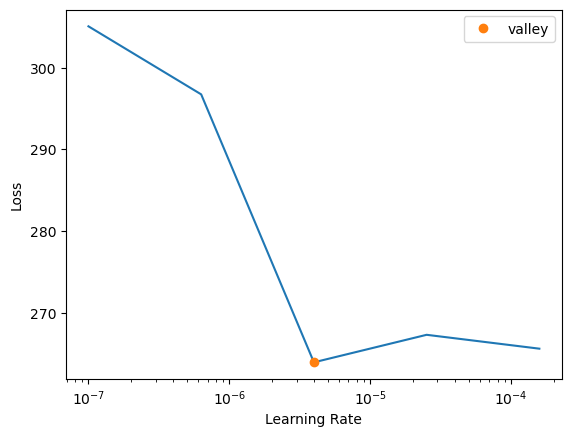

In [37]:
# #| hide
# with tempfile.TemporaryDirectory() as base_dir:
    
#     config_path = '../configs/cifar10/bt_test_config.yaml'
#     config = load_config(config_path)

#     # config.model_type = 'sparse_head_barlow_twins'
#     # config.sparsity_level=10
#     # config.epochs=100
#     # config.save_interval=100

#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)
    
#     print(os.listdir(experiment_dir))
#     print(os.listdir(base_dir))
#     print('experiment_dir and base_dir')


#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)
#     print(os.listdir(experiment_dir))
#     print(os.listdir(base_dir))
#     print('experiment_dir and base_dir')

#     #get path to fully fitted model
#     path = os.path.join(experiment_dir,f'trained_model_epoch_{config.epochs-1}.pth')
#     model = load_barlow_model(arch=config.arch,ps=config.ps,hs=config.hs,path=path)
#     print(model)

#     #New config but the first part of experiment_dir is same - just hash is different
#     #It shouldnt find a max file path
#     config.epochs=config.epochs+1
#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)


    


Full end to end example for vicreg

In [51]:
# #| hide
# with tempfile.TemporaryDirectory() as base_dir:
    
#     config_path = '../configs/cifar10/vicreg_test_config.yaml'
#     config = load_config(config_path)

#     # config.model_type = 'sparse_head_barlow_twins'
#     # config.sparsity_level=10
#     # config.epochs=100
#     # config.save_interval=100

#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)
    
#     print(os.listdir(experiment_dir))
#     print(os.listdir(base_dir))
#     print('experiment_dir and base_dir')

#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)
#     print(os.listdir(experiment_dir))
#     print(os.listdir(base_dir))
#     print('experiment_dir and base_dir')

#     #get path to fully fitted model
#     path = os.path.join(experiment_dir,f'trained_model_epoch_{config.epochs-1}.pth')
#     model = load_vicreg_model(arch=config.arch,ps=config.ps,hs=config.hs,path=path)
#     print(model)

#     #New config but the first part of experiment_dir is same - just hash is different
#     #It shouldnt find a max file path
#     config.epochs=config.epochs+1
#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)


    


The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmp6m8s5nvw/SSL/cifar10/smallres/9a227c39 and the experiment hash is: 9a227c39
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmp6m8s5nvw/SSL/cifar10/smallres/9a227c39/config.yaml
The git hash is: 021a355dc6c47c920af0ca9ad01f6544ff57ac40
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmp6m8s5nvw/SSL/cifar10/smallres/9a227c39 for highest num saved


AssertionError: ==:
False
True

Verify runs with br_vicreg

In [54]:
# #| hide
# with tempfile.TemporaryDirectory() as base_dir:
    
#     config_path = '../configs/cifar10/vicreg_test_config.yaml'
#     config = load_config(config_path)
#     config.model_type = 'br_vicreg'
#     config.arch = 'cifar_resnet18'

#     pretty_print_ns(config)
#     experiment_dir,experiment_hash = main_bt_experiment(config,base_dir)

dataset: cifar10
arch: cifar_resnet18
train_type: SSL
weight_type: random
size: 32
n_in: 3
bs: 128
ps: 512
hs: 512
bt_augs: bt_cifar10_aug_pipelines
model_type: br_vicreg
sim_coeff: 25.0
std_coeff: 25.0
cov_coeff: 1.0
sparsity_level: None
shared_projector: True
shared_encoder: True
wd: 1.5e-06
freeze_epochs: None
num_it: 10
pct_dataset: 0.003
epochs: 6
save_interval: 3
encoder_dimension: 512
The experiment_dir is: /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmp5u6a09uw/SSL/cifar10/cifar_resnet18/89066930 and the experiment hash is: 89066930
Configuration saved to /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmp5u6a09uw/SSL/cifar10/cifar_resnet18/89066930/config.yaml
The git hash is: 021a355dc6c47c920af0ca9ad01f6544ff57ac40
Looking in /var/folders/95/qkdymsl93lz1tvnqky1vn_p00000gn/T/tmp5u6a09uw/SSL/cifar10/cifar_resnet18/89066930 for highest num saved


Input shape: torch.Size([256, 3, 32, 16])
Augmented left half shape: torch.Size([128, 3, 32, 16])
Augmented right half shape: torch.Size([128, 3, 32, 16])
Combined batch shape: torch.Size([256, 3, 32, 16])


KeyboardInterrupt: 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()